In [4]:
import numpy as np

## 매개변수 갱신

### SGD
$$
\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$

In [2]:
# SGD 구현
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD 단점
* 문제에 따라 비효율적일 수 있음
* $f(x,y) = \frac{1}{20} x^2 + y^2$의 기울기의 대부분은 최솟값이 되는 지점(0, 0)을 가리키지 않는다.
* 위 식에서 결로가 지그재그로 그려지며 비효율적으로 학습하게 된다.
* 비등방성(anisotropy)함수(방향에 따라 성질, 즉 기울기가 달라지는 함수)에서는 탐색 결로가 비효율적이다.

### 모멘텀
$$
\mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} + \mathbf{v}
$$

In [5]:
# 모멘텀
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9) -> None:
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

* 바닥을 구르듯 움직인다.
* SGD와 비교해 지그재그 정도가 덜하다.
* x축의 힘은 작지만 방향이 변하지 않아 가속된다.

### AdaGrad
* **학습률 감소(learning rate decay)**: 학습률을 점차 줄여가는 방법
* 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행한다.
$$
\mathbf{h} \leftarrow \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} \times \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{1}{\sqrt \mathbf{h}} \frac{\partial L}{\partial \mathbf{W}}
$$
* 매개변수의 원소 중 많이 움직인(크게 갱신된) 원소는 학습률이 빠르게 낮아진다.

In [6]:
# AdaGrad
class AdaGrad:
    def __init__(self, lr=0.01) -> None:
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

* y축의 방향ㅇ은 기울기가 커서 처음엔 크게 움직이지만, 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정된다.
* 지그재그 움직임이 줄어든다.

### Adam
* 모멘텀 + AdaGrad
* 그룻 바닥을 구르듯 움직인다.
* 모멘텀과 비슷한 움직임이지만 좌우 흔들림이 적다.

### 비교

===========iteration:0===========
SGD       : 2.364
Momentum  : 2.390
AdaGrad   : 2.073
Adam      : 2.180
===========iteration:100===========
SGD       : 1.598
Momentum  : 0.431
AdaGrad   : 0.174
Adam      : 0.324
===========iteration:200===========
SGD       : 0.781
Momentum  : 0.167
AdaGrad   : 0.065
Adam      : 0.116
===========iteration:300===========
SGD       : 0.547
Momentum  : 0.259
AdaGrad   : 0.133
Adam      : 0.178
===========iteration:400===========
SGD       : 0.512
Momentum  : 0.224
AdaGrad   : 0.112
Adam      : 0.141
===========iteration:500===========
SGD       : 0.369
Momentum  : 0.161
AdaGrad   : 0.059
Adam      : 0.098
===========iteration:600===========
SGD       : 0.243
Momentum  : 0.149
AdaGrad   : 0.035
Adam      : 0.086
===========iteration:700===========
SGD       : 0.376
Momentum  : 0.181
AdaGrad   : 0.083
Adam      : 0.105
===========iteration:800===========
SGD       : 0.334
Momentum  : 0.170
AdaGrad   : 0.091
Adam      : 0.116
===========iteration:900======

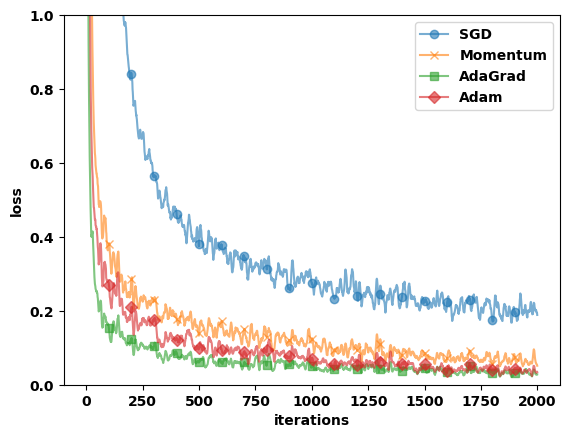

In [10]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(f'{key:10}: {loss:-5.3f}')


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key, alpha=0.6)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 가중치의 초깃값
* **가중치 감소(weight decay)**: 가중치 매개변수의 값이 작아지도록 하습하는 방법. 값을 작게 해 오버피팅을 방지한다.
* 가중치의 초깃값이 같으면 학습이 되지 않는다.

### 은닉층의 활성화값 분포

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 표준편차를 1로 한 경우
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

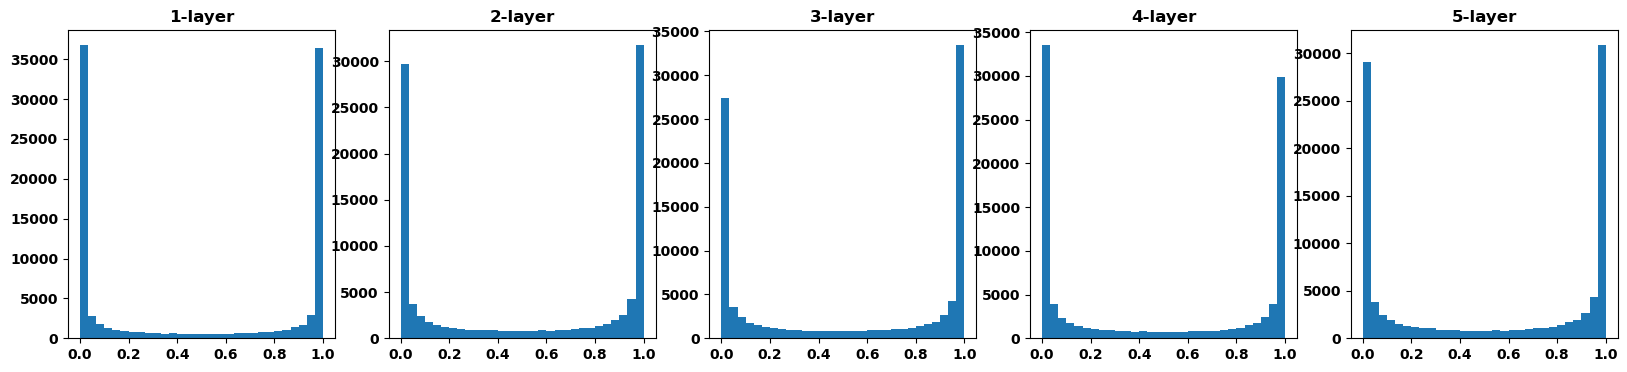

In [18]:
plt.figure(figsize=(20, 4))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f'{str(i+1)}-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

* 활성화 함수 값들이 0과 1에 치우쳐 분포되어 있다.
* **기울기 소실(gradient vanishing)**: 시그모이드 함수의 출력이 0과 1에 가까워 질수록 미분값은 0에 다가간다. 따라서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다.

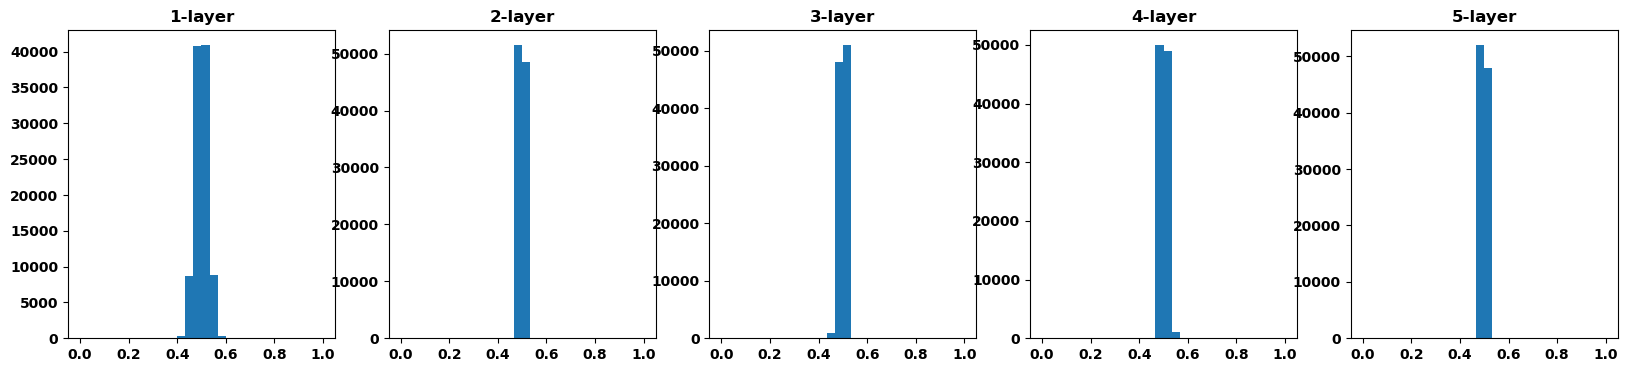

In [20]:
# 표준편차를 0.01로 한 경우
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

plt.figure(figsize=(20, 4))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f'{str(i+1)}-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

* 활성화값들이 치우치게 되면 **표현력이 제한**된다.

### Xavier 초깃값
* 앞 계층의 노드가 n개이면 표준편차가 $\frac{1}{\sqrt n}$인 분포를 사용하는 초기화 방식

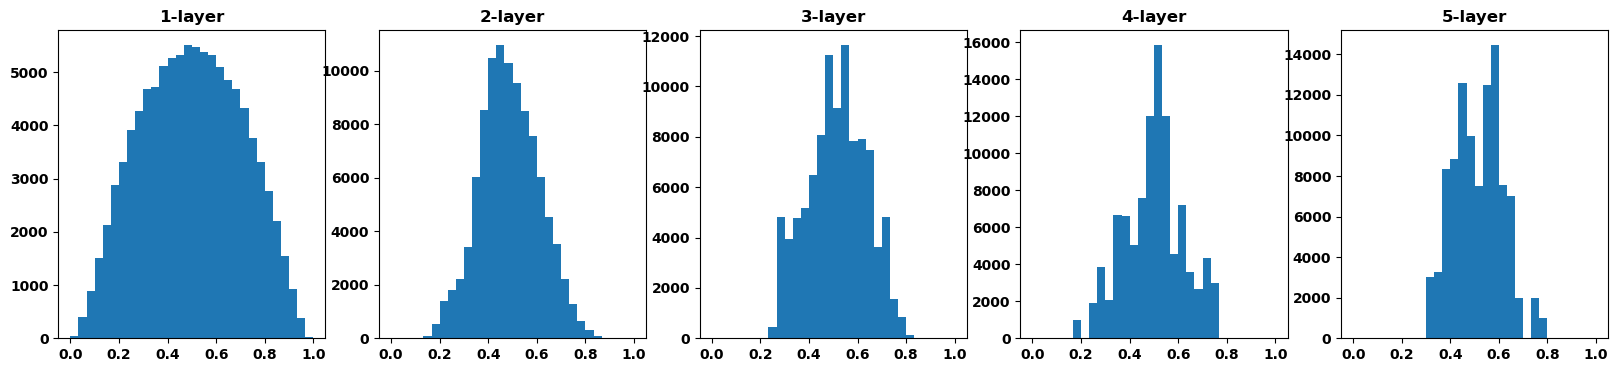

In [22]:
# xavier 초깃값
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

plt.figure(figsize=(20, 4))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f'{str(i+1)}-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### ReLU 사용, He 초깃값
* 활성화 함수로 ReLU함수 사용 시, **He 초깃값** 사용
* 앞 계층의 노드가 n개 일 때, 표준편차가 $\sqrt \frac{2}{n}$ 인 정규분포 사용

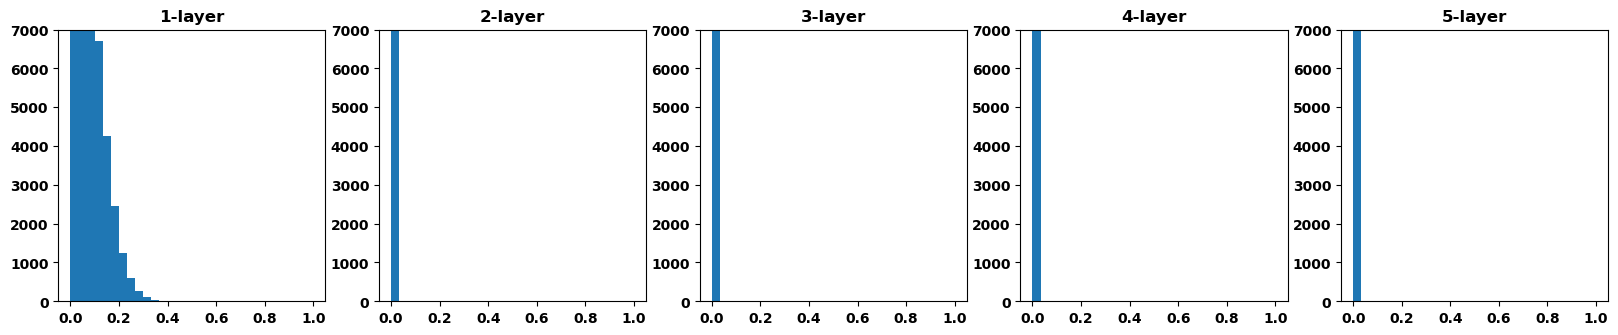

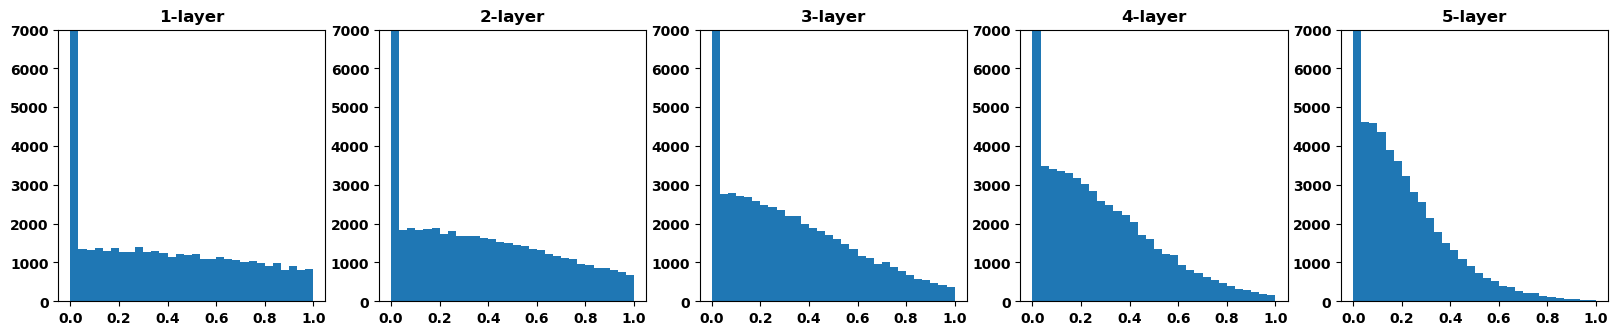

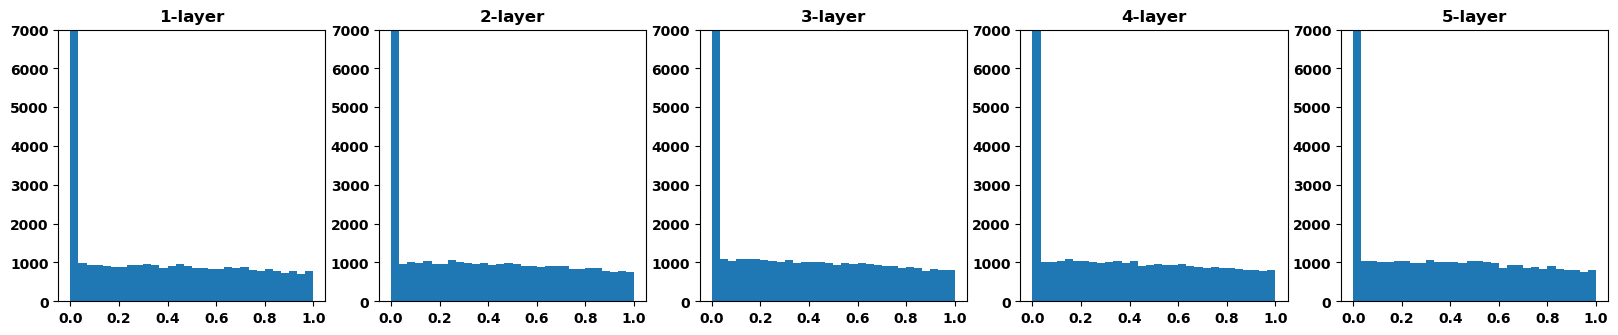

In [40]:
def relu(x):
    return np.maximum(x, 0)


node_num = 100
hidden_layer_size = 5

stds = [0.01, 1/np.sqrt(node_num), np.sqrt(2/node_num)]

for idx in range(len(stds)):
    x = np.random.randn(1000, 100)
    activations = {}
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num, node_num) * stds[idx]
        a = np.dot(x, w)
        z = relu(a)
        activations[i] = z

    plt.figure(figsize=(20, 12))
    for i, a in activations.items():
        plt.subplot(3, len(activations), i+1)
        plt.title(f'{str(i+1)}-layer')
        plt.hist(a.flatten(), 30, range=(0,1))
        plt.ylim(0, 7000)
    plt.show()


### 초깃값 비교

===========iteration:0===========
std=0.01:2.30251299828835
Xavier:2.2881386842082687
He:2.3318891468243494
===========iteration:100===========
std=0.01:2.3027859258912757
Xavier:2.240511214254856
He:1.4694922454396566
===========iteration:200===========
std=0.01:2.301029314141937
Xavier:2.0729390998875936
He:0.6078313707699357
===========iteration:300===========
std=0.01:2.303330884092283
Xavier:1.8442442379344282
He:0.5629460027666264
===========iteration:400===========
std=0.01:2.301940619755786
Xavier:1.280713993802151
He:0.4972941786773266
===========iteration:500===========
std=0.01:2.300601362381391
Xavier:0.817105739719993
He:0.3354437426715111
===========iteration:600===========
std=0.01:2.302776494537114
Xavier:0.5662358125956656
He:0.26377429259932966
===========iteration:700===========
std=0.01:2.299141762840729
Xavier:0.5741342156996108
He:0.3955682232271502
===========iteration:800===========
std=0.01:2.3058909408227897
Xavier:0.5092238199037653
He:0.3435083286833164
====

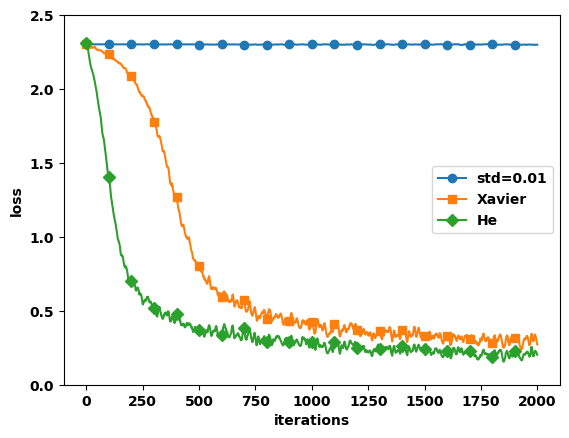

In [41]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 배치 정규화
* 학습 속도 개선
* 초깃값에 크게 의존하지 않는다.
* 오버피팅 억제(드롭아웃 필요성 감소)
* 평균이 0, 분산이 1이 되도록 정규화
$$
\mu_B \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i\\
\sigma_B^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m}(x_i - \mu_B)^2\\
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sigma_B^2 + \epsilon}
$$
* 활성화 함수의 앞(혹은 뒤)에 삽입함으로써 데이터 분포가 덜 치우치게 된다.

### 효과

c:\AI_Study\Team5\박성민\Deep_Learning_from_Scratch\ch06\..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
c:\AI_Study\Team5\박성민\Deep_Learning_from_Scratch\ch06\..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


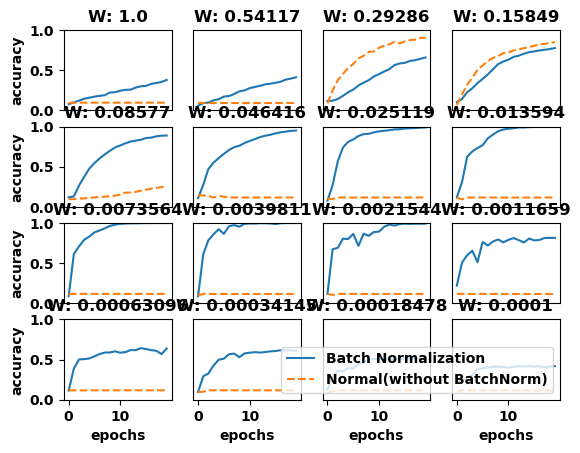

<Figure size 3000x3000 with 0 Axes>

In [46]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            # print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)


for i, w in enumerate(weight_scale_list):
    #print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title(f'W: {w:.5}')
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")


plt.legend(loc='lower right')
    
plt.figure(figsize=(30, 30))
plt.show()

가중치 초깃값을 설정한 대부분의 경우에서 정규화를 사용할 때 학습 진도가 빠르다.

## 바른학습

### 오버피팅
* 매개변수가 많고 표현력이 높은 모델(복잡도가 높은 모델)
* 훈련 데이터가 적을 때 

### 가중치 감소
* 큰 가중치에 대해서 큰 페널틸르 부과하여 오버피팅을 어제하는 방법

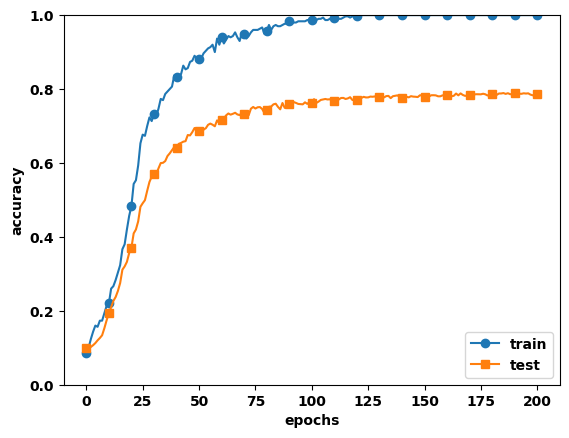

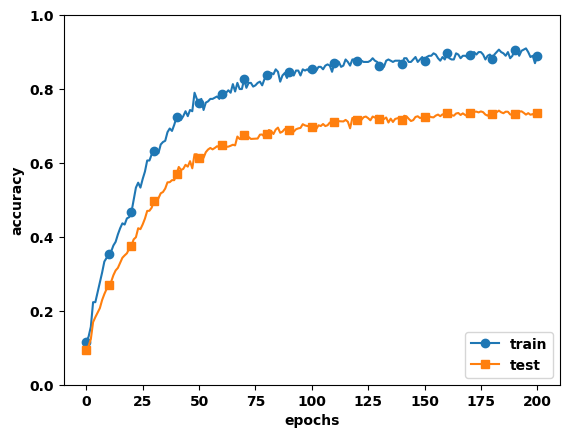

In [50]:
# 오버피팅(훈련 데이터가 적고, 복잡도가 높을 때)
# coding: utf-8
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
weight_decay_lambdas = [0, 0.1]
# ====================================================

optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

for weight_decay_lambda in weight_decay_lambdas:
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            weight_decay_lambda=weight_decay_lambda)

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            # print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break


    # 그래프 그리기==========
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(max_epochs)
    plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

### 드롭아웃
* 신경망 모델이 복잡해지면 가중치 감소만으로 대응하기 어려워진다
* 뉴런을 임의로 삭제하면서 학습시키는 방법(ex. 무작위 삭제)
* 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력한다.

train loss:2.376470508390906
=== epoch:1, train acc:0.10666666666666667, test acc:0.0982 ===
train loss:2.365240122750441
train loss:2.3112529122983427
train loss:2.2724329745347798
=== epoch:2, train acc:0.14, test acc:0.1053 ===
train loss:2.321251199281749
train loss:2.233163370436151
train loss:2.266732370715089
=== epoch:3, train acc:0.17666666666666667, test acc:0.1167 ===
train loss:2.2425162433244985
train loss:2.294645184025481
train loss:2.2433009291359283
=== epoch:4, train acc:0.2, test acc:0.1339 ===
train loss:2.245686769811521
train loss:2.1803765414490064
train loss:2.2206755182883784
=== epoch:5, train acc:0.23, test acc:0.163 ===
train loss:2.1515972058884487
train loss:2.187660684284726
train loss:2.2070339970232715
=== epoch:6, train acc:0.27, test acc:0.1884 ===
train loss:2.1352459199234044
train loss:2.148285077535735
train loss:2.1337727754560563
=== epoch:7, train acc:0.31, test acc:0.2125 ===
train loss:2.1428065023315277
train loss:2.077697625893325
train los

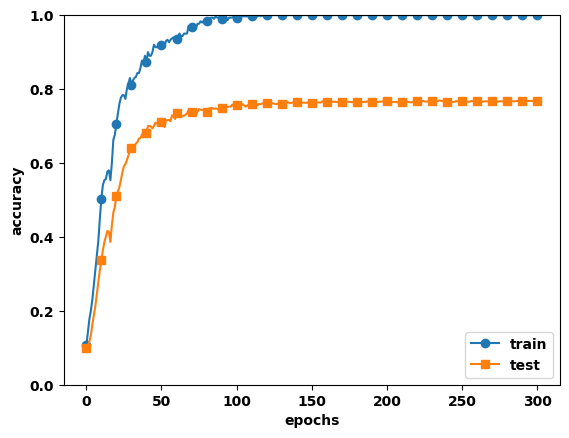

train loss:2.3094206489140454
=== epoch:1, train acc:0.09666666666666666, test acc:0.1032 ===
train loss:2.298123147647557
train loss:2.33848346354839
train loss:2.323265436513425
=== epoch:2, train acc:0.09666666666666666, test acc:0.1035 ===
train loss:2.3197845164247095
train loss:2.3388870508922865
train loss:2.330585175534934
=== epoch:3, train acc:0.09666666666666666, test acc:0.104 ===
train loss:2.3051203722169102
train loss:2.310235398654765
train loss:2.3025463791922194
=== epoch:4, train acc:0.09666666666666666, test acc:0.1049 ===
train loss:2.3192820467733797
train loss:2.307039269031072
train loss:2.325387358464033
=== epoch:5, train acc:0.09666666666666666, test acc:0.106 ===
train loss:2.301564715086954
train loss:2.3270298966469767
train loss:2.2982112880745675
=== epoch:6, train acc:0.1, test acc:0.107 ===
train loss:2.3136610149330026
train loss:2.291177378600766
train loss:2.3195071879608373
=== epoch:7, train acc:0.1, test acc:0.1084 ===
train loss:2.30463090237106

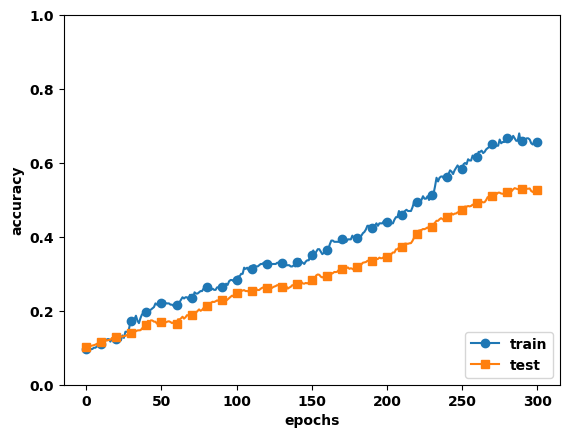

In [51]:
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
# use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

for use_dropout in (False, True):
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                                output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                    epochs=301, mini_batch_size=100,
                    optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
    trainer.train()

    train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

    # 그래프 그리기==========
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(len(train_acc_list))
    plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

## 적절한 하이퍼파라미터 값 찾기

### 검증 데이터
* 하이퍼파라미터를 조정할 때 시험 데이터로하면 하이퍼파라미터가 시험 데이터에 오버피팅될 수 있으므로, 검증 데이터를 두어 하이퍼파라미터의 값을 조정한 뒤, 테스트 세트는 마지막에 범용 성능을 평가할 때 사용한다.

### 하이퍼파라미터 최적화
> [베이즈 최적화 참고](https://proceedings.neurips.cc/paper/2012/file/05311655a15b75fab86956663e1819cd-Paper.pdf)

val acc:0.06 | lr:1.0905185641630574e-06, weight decay:4.99064216005156e-06
val acc:0.13 | lr:0.00020882924181590568, weight decay:1.3863740839647365e-06
val acc:0.13 | lr:1.0470270734806804e-05, weight decay:4.694106371451709e-05
val acc:0.13 | lr:9.07265683970922e-05, weight decay:5.837807199835965e-06
val acc:0.54 | lr:0.003935206512978511, weight decay:1.6075904004047134e-05
val acc:0.06 | lr:6.18491090790415e-05, weight decay:3.684856895117489e-08
val acc:0.51 | lr:0.0022899667671146505, weight decay:7.058729967682448e-07
val acc:0.15 | lr:1.5487562938699558e-05, weight decay:3.796659633173865e-08
val acc:0.62 | lr:0.005788204862321059, weight decay:3.073832209289973e-08
val acc:0.27 | lr:0.0014045299781828592, weight decay:1.399849021713935e-08
val acc:0.53 | lr:0.003132259836512607, weight decay:9.075782015789466e-08
val acc:0.11 | lr:2.8078145522427743e-06, weight decay:2.2244130783463925e-06
val acc:0.11 | lr:6.030069483086915e-05, weight decay:1.7654172804676232e-06
val acc:0

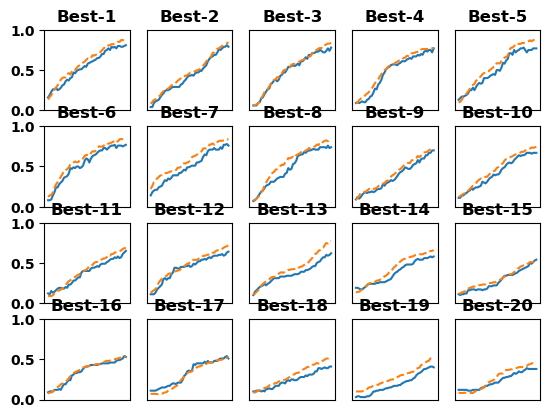

In [52]:
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()